# Train multiple models on tiles
Use the fastai package to:
1. Check if their lr schedule, models, etc. perform resonably compared to pytorch implementation in "tile_classifier"
2. Get idea of which models performs best 
3. See if ensembling models is useful, given that they are all trained on the same data
  1. Try training the same model multiple times with same data and ensembling
  2. Training different models and ensembling
  
  
** All of this is using the fastai conda env **

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from torchvision import datasets, models, transforms

# Base Directory where data is stored
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

# Set it to use GPU1
torch.cuda.set_device(1)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
1


In [2]:
# put the models trained on a dataset in it
if not os.path.exists(os.path.join(PATH,'models')):
    os.makedirs(os.path.join(PATH,'models'))
if not os.path.exists(os.path.join(PATH,'sample')):
    os.makedirs(os.path.join(PATH,'sample'))

## Fast ai way of training

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|███████   | 913/1302 [03:13<01:22,  4.71it/s, loss=1.32] 

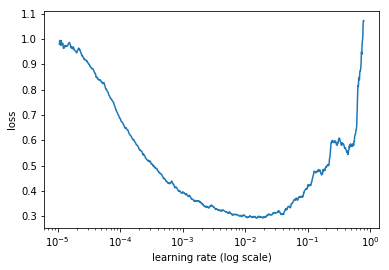

In [8]:
sz=224 # downsample to the same size for resnet
arch=resnet34
# look at 64 batch size, because this is what we will be using:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=64)  
learn = ConvLearner.pretrained(arch, data, precompute=False)
lrf=learn.lr_find(start_lr=1e-5, end_lr=100)
learn.sched.plot(n_skip=5, n_skip_end=1)

Rate of change of loss is steepest around .0005, and largest acceptable is .005

In [10]:
lr =.001

arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [11]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  0%|          | 0/2604 [00:00<?, ?it/s]                     


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.247132   0.20892    0.910603  
    1      0.237638   0.199524   0.914435                      



[0.1995242, 0.9144345237605873]

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.224544   0.170514   0.928742  
    1      0.176723   0.156928   0.933592                      
    2      0.173413   0.155261   0.933831                      
    3      0.170709   0.155607   0.932942                      
    4      0.141842   0.14485    0.940955                      
    5      0.153905   0.146337   0.941964                      
    6      0.199034   0.152068   0.937543                      



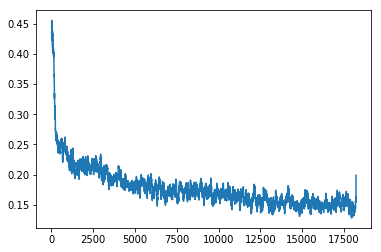

In [13]:
lrs = np.array([lr/10,lr/5,lr])

learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name='resnet50_full_fastai')
learn.sched.plot_loss()

### Try on bigger dataset to see if it improves performance 
(same train/valid split so will be fine)

In [ ]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_1m/'

arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)

learn.load('/media/rene/Data/camelyon_out/tiles_224_100t/models/resnet50_full_fastai')

lr =.001
lrs = np.array([lr/10,lr/5,lr])
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, best_save_name='resnet50_full_fastai_1m')
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  1%|          | 200/26031 [01:42<3:40:24,  1.95it/s, loss=0.139]

#### Did the bigger dataset help? How the 100t validation set differs from 1m:

In [4]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('/media/rene/Data/camelyon_out/tiles_224_100t/models/resnet50_full_fastai')
preds, y = learn.predict_with_targs(is_test=False)
print('100t validation set w/ 100t model: ',accuracy_np(preds, y))

arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('/media/rene/Data/camelyon_out/tiles_224_1m/models/resnet50_full_fastai_1m')
preds, y = learn.predict_with_targs(is_test=False)
print('100t validation set with 1m model: ', accuracy_np(preds, y))

PATH = '/media/rene/Data/camelyon_out/tiles_224_1m/'
arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('/media/rene/Data/camelyon_out/tiles_224_1m/models/resnet50_full_fastai_1m')
preds, y = learn.predict_with_targs(is_test=False)
print('1m validation set with 1m model: ', accuracy_np(preds, y))

100t validation set w/ 100t model:  0.9419760479041916
100t validation set with 1m model:  0.9444311377245509
1m validation set with 1m model:  0.9439108513670494


#### As expected, using the bigger dataset is better, but not by much

Try training all layers at same lr:

In [2]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
lr =.001

arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=50)
learn = ConvLearner.pretrained(arch, data, precompute=False)

learn.fit(lr, 2, cycle_len=1, cycle_mult=1)

lr =.001
lrs = np.array([lr, lr, lr])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name='resnet50_evenlr')
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.25362    0.205661   0.912455  
    1      0.226049   0.203902   0.911916                      



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.175984   0.157005   0.932874  
    1      0.164254   0.134429   0.946886                      
    2      0.143309   0.139744   0.943713                      
    3      0.143628   0.139568   0.943892                      
    4      0.122835   0.146198   0.940778                      
  4%|▎         | 60/1666 [00:20<09:05,  2.95it/s, loss=0.121]

KeyboardInterrupt: 

In [3]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('/media/rene/Data/camelyon_out/tiles_224_100t/models/resnet50_evenlr')
preds, y = learn.predict_with_targs(is_test=False)
print('100t validation set w/ 100t model: ', accuracy_np(preds, y))

100t validation set w/ 100t model:  0.9468862275449101


#### Training resnet50 without fastai leads to about the same performance (about .94)

# Train final layer in models
models:
* resnet34
* resnet50
* resnet101
* vgg16
* resnext50
* resnext101
* inceptionresnet_2
* inception_4
* dn121
* dn169

** Does it matter if we read in the 224x224, or scale the 299x299? ** 

In [ ]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

lr=np.array([1e-3,5e-3,1e-2])

for idx, arch in enumerate(models):
    if arch in [inceptionresnet_2, inception_4]:
        sz = 299
        PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'
    else:
        sz = 224
        PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'

    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms)
    
    print(models_name[idx])
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name[idx])

resnet34


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/1302 [00:00<?, ?it/s]                  


Exception in thread Thread-420:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.255341   0.231327   0.895518  
    1      0.253622   0.231133   0.893491                      
    2      0.242353   0.224276   0.898388                      
    3      0.248091   0.227568   0.89899                       
    4      0.258412   0.215891   0.903716                      
    5      0.235607   0.214045   0.902698                      
    6      0.227546   0.212328   0.903776                      

resnet50


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.236542   0.208497   0.905152  
    1      0.229533   0.193573   0.910189                      
    2      0.21807    0.19953    0.908928                      
    3      0.222059   0.203794   0.906294                      
    4      0.208814   0.193822   0.913586                      
    5      0.207671   0.193967   0.912153                      
    6      0.209226   0.188228   0.916994                      

resnet101


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.237373   0.207407   0.902522  
    1      0.227158   0.190388   0.914376                      
    2      0.215104   0.187965   0.915274                      
    3      0.219308   0.190654   0.913418                      
    4      0.211119   0.179419   0.918866                      
    5      0.213924   0.179406   0.92138                       
    6      0.201884   0.180645   0.92132                       

vgg16


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.266662   0.232219   0.893718  
    1      0.249728   0.224433   0.898867                      
    2      0.254703   0.215796   0.902279                      
    3      0.244774   0.216093   0.90198                       
    4      0.254539   0.222483   0.895993                      
    5      0.237156   0.208507   0.905803                      
    6      0.230583   0.208373   0.904785                      

resnext50


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.223736   0.207713   0.905456  
    1      0.220997   0.195159   0.914017                      
    2      0.223653   0.191198   0.91677                       
    3      0.224033   0.188591   0.915633                      
    4      0.212011   0.184905   0.918143                      
    5      0.203431   0.185212   0.916531                      
    6      0.210347   0.18279    0.9197                        

resnext101


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.23134    0.194227   0.913119  
    1      0.226533   0.189073   0.913957                      
    2      0.206577   0.18417    0.917609                      
    3      0.211413   0.190894   0.91246                       
    4      0.207527   0.180603   0.922039                      
    5      0.213245   0.182499   0.918746                      
    6      0.197984   0.178461   0.920243                      

inceptionresnet_2


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.247449   0.228005   0.897071  
    1      0.247835   0.221427   0.903177                      
    2      0.241098   0.211291   0.905811                      
    3      0.230133   0.212111   0.908086                      
  6%|▌         | 81/1302 [00:40<10:04,  2.02it/s, loss=0.239]

## Test Models:

In [2]:
def get_ensemble_acc(models, models_name, PATH, weights=None):
    # weights must be in the same order corresponding to model
    if weights is None:
        weights = [1/len(models)]*len(models)
    all_preds = []
    
    for idx, arch in enumerate(models):
        if arch in [inceptionresnet_2, inception_4]:
            sz = 299
        else:
            sz = 224

        tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1)
        data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=64)

        model_loc = os.path.join(PATH, 'models', models_name[idx])
        learn = ConvLearner.pretrained(arch, data, precompute=False)
        learn.load(model_loc)
        preds, y = learn.predict_with_targs(is_test=False)
        print(models_name[idx], ':   ', accuracy_np(preds, y))
        all_preds.append(preds)
        
    all_preds = np.array(all_preds)
    probs = np.average(np.exp(all_preds), axis=0, weights=weights)
    print(accuracy_np(probs, y))

In [83]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'

get_ensemble_acc(models, models_name, PATH)

resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9224550898203593


### Try removing the worst models

In [15]:
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'
models_arch = [resnet50, resnet101, resnext50, resnext101, inceptionresnet_2, dn121, dn169]
models_name = ['resnet50', 'resnet101', 'resnext50', 'resnext101', 'inceptionresnet_2', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH)

resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9273652694610779


### Weighted average

In [3]:
perf = [0.9037, 0.917, 0.921, 0.9058, 0.9197, 0.922, 0.913, 0.901, 0.920, 0.924]
perf = [1/(1-x) for x in perf]
perf = np.power(perf, 1)
weights = perf/(len(perf)*np.mean(perf))
print(weights)

[0.08783 0.1019  0.10706 0.08979 0.10533 0.10843 0.09722 0.08543 0.10572 0.11129]


In [4]:
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'

models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH, weights)

resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9229341317365269


In [5]:
perf = [0.9037, 0.917, 0.921, 0.9058, 0.9197, 0.922, 0.913, 0.901, 0.920, 0.924]
perf = [1/(1-x) for x in perf]
perf = np.power(perf, 2)
weights = perf/(len(perf)*np.mean(perf))
print(weights)

models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH, weights)

[0.07654 0.10303 0.11373 0.07999 0.11008 0.11666 0.09377 0.07242 0.1109  0.12288]
resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9231137724550899


In [6]:
perf = [0.9037, 0.917, 0.921, 0.9058, 0.9197, 0.922, 0.913, 0.901, 0.920, 0.924]
perf = [1/(1-x) for x in perf]
perf = np.power(perf, 4)
weights = perf/(len(perf)*np.mean(perf))
print(weights)

models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH, weights)

[0.05689 0.10309 0.12561 0.06213 0.11767 0.13218 0.0854  0.05093 0.11945 0.14665]
resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9249101796407185


In [6]:
perf = [0.9037, 0.917, 0.921, 0.9058, 0.9197, 0.922, 0.913, 0.901, 0.920, 0.924]
perf = [1/(1-x) for x in perf]
perf = np.power(perf, 6)
weights = perf/(len(perf)*np.mean(perf))
print(weights)

models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH, weights)

[0.04124 0.10061 0.13532 0.04708 0.1227  0.14607 0.07586 0.03494 0.12548 0.1707 ]
resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9261676646706587


In [4]:
perf = [0.9037, 0.917, 0.921, 0.9058, 0.9197, 0.922, 0.913, 0.901, 0.920, 0.924]
perf = [1/(1-x) for x in perf]
perf = np.power(perf, 8)
weights = perf/(len(perf)*np.mean(perf))
print(weights)

models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH, weights)

[0.02929 0.0962  0.14281 0.03494 0.12533 0.15813 0.06601 0.02348 0.12914 0.19466]
resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.927065868263473


In [7]:
perf = [0.9037, 0.917, 0.921, 0.9058, 0.9197, 0.922, 0.913, 0.901, 0.920, 0.924]
perf = [1/(1-x) for x in perf]
perf = np.power(perf, 12)
weights = perf/(len(perf)*np.mean(perf))
print(weights)

models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH, weights)

[0.01411 0.08394 0.15183 0.01838 0.12483 0.17691 0.04772 0.01012 0.13056 0.24162]
resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9278443113772455


## Train the same model multiple times - resnet34

In [7]:
models_arch = resnet34
models_name = 'resnet34'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'

for i in range(5):
    print(i)
    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=128)

    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i))

0


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.254224   0.243983   0.889945  
    1      0.25155    0.224462   0.898108                    
    2      0.245538   0.229374   0.895185                    
    3      0.241307   0.227773   0.898465                    
    4      0.238781   0.226091   0.895953                    
    5      0.236224   0.222337   0.89942                     
    6      0.228867   0.222782   0.898994                    

1


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.25303    0.236267   0.890303  
    1      0.241575   0.235124   0.891555                    
    2      0.231444   0.23218    0.89245                     
    3      0.241005   0.219871   0.897698                    
    4      0.240089   0.224595   0.895356                    
    5      0.229602   0.219286   0.899062                    
    6      0.230578   0.224274   0.896676                    

2


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.248402   0.249809   0.883922  
    1      0.250581   0.231077   0.891488                    
    2      0.2427     0.228099   0.893814                    
    3      0.238899   0.236376   0.891384                    
    4      0.235692   0.227526   0.894283                    
    5      0.23145    0.22216    0.897273                    
    6      0.230786   0.218849   0.899718                    

3


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.256681   0.239173   0.891905  
    1      0.241265   0.230382   0.89666                     
    2      0.241284   0.226763   0.897332                    
    3      0.240192   0.231743   0.892382                    
    4      0.229422   0.225151   0.896489                    
    5      0.232788   0.218636   0.89965                     
    6      0.232905   0.219864   0.899054                    

4


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.251089   0.242452   0.887253  
    1      0.24526    0.235694   0.88876                     
    2      0.247952   0.240224   0.886256                    
    3      0.252173   0.230077   0.893293                    
    4      0.237314   0.223379   0.89971                     
    5      0.231811   0.223312   0.897921                    
    6      0.237432   0.22538    0.897444                    



In [5]:
models_arch = [resnet34 for i in range(5)]
models_name = ['resnet34_'+str(i) for i in range(5)]

get_ensemble_acc(models_arch, models_name, PATH)

resnet34_0 :    0.8992814371257485
resnet34_1 :    0.8989221556886228
resnet34_2 :    0.8995808383233533
resnet34_3 :    0.8995808383233533
resnet34_4 :    0.8996407185628742
0.9007784431137724


## Dense Net 169

In [ ]:
models_arch = dn169
models_name = 'dn169'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'

for i in range(10):
    print(i)
    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms)

    learn = ConvLearner.pretrained(arch, data, precompute=False)
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i))

0


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.216709   0.192454   0.913115  
 33%|███▎      | 431/1302 [01:18<02:37,  5.52it/s, loss=0.239]

In [7]:
models_arch = [dn169 for i in range(10)]
models_name = ['dn169_'+str(i) for i in range(10)]

get_ensemble_acc(models_arch, models_name, PATH)

dn169_0 :    0.9246107784431138
dn169_1 :    0.9240718562874252
dn169_2 :    0.9217365269461077
dn169_3 :    0.9230538922155689
dn169_4 :    0.9232934131736527
dn169_5 :    0.9217964071856287
dn169_6 :    0.922874251497006
dn169_7 :    0.9255688622754491
dn169_8 :    0.9238323353293413
dn169_9 :    0.9235329341317365
0.9248502994011976


#### Ensembling dn169 doesn't give much improvement

## Fine-tuning models
* Previously only fine tuned the last few layers
* Setting an array of learning rates was pointless, because most of the model wasn't set to trainable.

In [ ]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

for idx, arch in enumerate(models_arch):
    print(models_name[idx])
    if arch in [inceptionresnet_2, inception_4]:
        sz = 299
        PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'
    else:
        sz = 224
        PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'
        
    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=12)
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name[idx]+'_full') # train whole model

inception_4


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 106/6942 [00:07<08:18, 13.71it/s, loss=0.702]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.290851   0.242755   0.891912  



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.198183   0.162045   0.931304  
    1      0.203252   0.143324   0.943756                      
    2      0.177112   0.149588   0.94196                       
    3      0.16727    0.147731   0.939266                      
    4      0.172608   0.144756   0.940763                      
 33%|███▎      | 2296/6942 [08:35<17:22,  4.46it/s, loss=0.176]

## Check accuracy with fine-tuned models
* Check weighted ensemble (whatever works best)
* Maybe check training a model multiple times

In [5]:
def get_best_ensemble_acc(models, models_name, PATH):
    perf = []
    all_preds = []
    
    for idx, arch in enumerate(models):
        if arch in [inceptionresnet_2, inception_4]:
            sz = 299
        else:
            sz = 224

        tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1)
        data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=64)

        model_loc = os.path.join(PATH, 'models', models_name[idx])
        learn = ConvLearner.pretrained(arch, data, precompute=False)
        learn.load(model_loc)
        preds, y = learn.predict_with_targs(is_test=False)
        print(models_name[idx], ':   ', accuracy_np(preds, y))
        perf.append(accuracy_np(preds, y))
        all_preds.append(preds)
        
    # Now try to find the optimal weighting. Use exponential to test.
    all_preds = np.array(all_preds)

    for power in range(0, 21, 3):
        _perf = [1/(1-x) for x in perf]
        _perf = np.power(_perf, power)
        weights = _perf/(len(_perf)*np.mean(_perf))
        print(weights)
        probs = np.average(np.exp(all_preds), axis=0, weights=weights)
        print('Power:', power, 'Accuracy: ', accuracy_np(probs, y))

In [6]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34_full', 'resnet50_full', 'resnet101_full', 'vgg16_full', 'resnext50_full', 'resnext101_full', 'inceptionresnet_2_full', 'inception_4_full', 'dn121_full', 'dn169_full']

get_best_ensemble_acc(models_arch, models_name, PATH)

resnet34_full :    0.9437125748502994
resnet50_full :    0.9455688622754491
resnet101_full :    0.9453892215568862
vgg16_full :    0.9433532934131736
resnext50_full :    0.9466467065868264
resnext101_full :    0.9458682634730539
inceptionresnet_2_full :    0.9395209580838323
inception_4_full :    0.9437724550898203
dn121_full :    0.9440718562874252
dn169_full :    0.9479041916167664
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Power: 0 Accuracy:  0.9517964071856287
[0.0946  0.10462 0.10359 0.09281 0.11109 0.10636 0.07626 0.09491 0.09644 0.11932]
Power: 3 Accuracy:  0.9516766467065868
[0.08839 0.10809 0.10597 0.08508 0.12187 0.11173 0.05744 0.08896 0.09185 0.14062]
Power: 6 Accuracy:  0.9516167664670658
[0.08164 0.1104  0.10717 0.07709 0.13217 0.11602 0.04277 0.08242 0.08648 0.16382]
Power: 9 Accuracy:  0.9518562874251497
[0.0746  0.11156 0.10724 0.06912 0.14183 0.1192  0.03151 0.07556 0.08056 0.18882]
Power: 12 Accuracy:  0.9516766467065868
[0.0675  0.11162 0.10624 0.06135 0.15068 0.1212

In [7]:
## Used wrong transforms in the training. Used resnet 50 for all

In [8]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'

models_arch = [dn169 for i in range(9)]
models_name = ['dn169_full_'+str(i) for i in range(9)]

get_best_ensemble_acc(models_arch, models_name, PATH)

dn169_full_0 :    0.9473053892215569
dn169_full_1 :    0.9489820359281437
dn169_full_2 :    0.947185628742515
dn169_full_3 :    0.9474251497005988
dn169_full_4 :    0.9480838323353293
dn169_full_5 :    0.9469461077844311
dn169_full_6 :    0.9459880239520958
dn169_full_7 :    0.9487425149700599
dn169_full_8 :    0.9464670658682635
[0.11111 0.11111 0.11111 0.11111 0.11111 0.11111 0.11111 0.11111 0.11111]
Power: 0 Accuracy:  0.9507185628742515
[0.10994 0.12113 0.10919 0.11069 0.11496 0.10772 0.10209 0.11944 0.10485]
Power: 3 Accuracy:  0.9507784431137725
[0.10846 0.13168 0.10699 0.10995 0.11859 0.10412 0.09352 0.12803 0.09866]
Power: 6 Accuracy:  0.9507185628742515
[0.10669 0.14273 0.10453 0.1089  0.12198 0.10036 0.08543 0.13683 0.09256]
Power: 9 Accuracy:  0.9507185628742515
[0.10464 0.15425 0.10183 0.10754 0.1251  0.09645 0.07781 0.14582 0.08658]
Power: 12 Accuracy:  0.9505389221556886
[0.10233 0.16621 0.0989  0.10588 0.12792 0.09241 0.07065 0.15493 0.08076]
Power: 15 Accuracy:  0.95071

## Fine-tuning same model multiple times

In [ ]:
arch = dn169
models_name = 'dn169_full'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

for i in range(10):
    print(i)
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=24)
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i)) # train whole model

0


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  1%|          | 40/3471 [00:03<05:12, 10.97it/s, loss=0.809]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 40%|███▉      | 1372/3471 [01:45<02:41, 13.00it/s, loss=0.274]

## Check Densenet on 299x299

In [ ]:
arch = dn169
models_name = 'dn169_full_299'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'

for i in range(1):
    print(i)
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=24)
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i)) # train whole model

0


epoch      trn_loss   val_loss   accuracy                      
    0      0.235758   0.203005   0.90976   



epoch      trn_loss   val_loss   accuracy                      
    0      0.184579   0.162162   0.932874  
    1      0.178161   0.145385   0.942275                      
 60%|█████▉    | 2080/3471 [06:54<04:37,  5.02it/s, loss=0.146]

In [4]:
models_arch = [dn169]
models_name = ['dn169']
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'

get_ensemble_acc(models_arch, models_name, PATH) 

dn169 :    0.9243712574850299
0.9243712574850299
